In [1]:
%load_ext autoreload
%autoreload 2

# Importing needed libraries

In [114]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from nltk import word_tokenize
import re
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
import umap

# Loading dataset

In [16]:
dataset = fetch_20newsgroups(subset='all',
                             categories=None,
                             shuffle=True,
                             random_state=42)
true_labels = dataset.target

In [4]:
data_pd = pd.DataFrame(dataset.data, columns=['message'])

# EDA

In [5]:
data_pd.shape

(18846, 1)

Distribution of text lengths

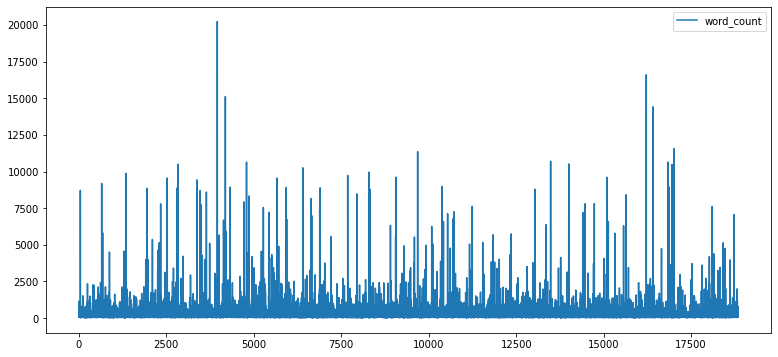

In [6]:
data_pd['word_count'] = data_pd['message'].apply(lambda x: len(str(x).split(" ")))
data_pd.plot(y='word_count', figsize=(13,6));

And histogramm of distribution

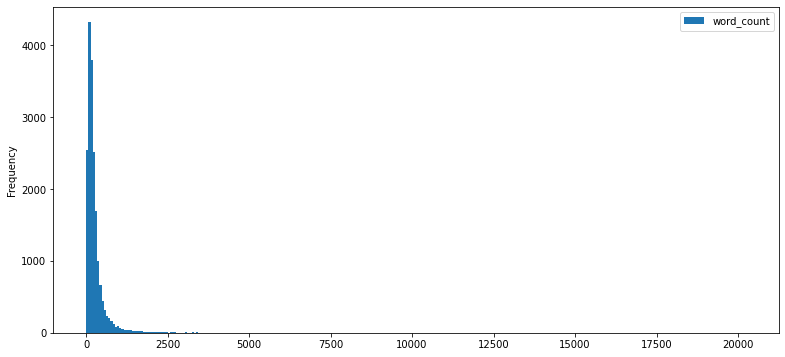

In [7]:
data_pd.plot(y='word_count', figsize=(13,6), kind='hist', bins=300);

As we can see, most of messages have length less than 500 words 

In [8]:
data_pd['word_count'].describe()

count    18846.000000
mean       315.039266
std        658.452218
min          9.000000
25%        110.000000
50%        187.000000
75%        314.000000
max      20235.000000
Name: word_count, dtype: float64

# Preprocessing

In [9]:
common_words = pd.Series(' '.join(data_pd['message']).split()).value_counts()
common_words[:25]

the         210209
to          115712
of          110387
a            92635
and          87109
is           64134
I            62414
in           61913
that         57465
>            46322
for          41833
you          33113
it           32091
on           29920
be           29430
have         28704
are          27723
with         26775
not          25453
The          22713
as           22257
this         22167
was          20840
or           20733
Subject:     19317
dtype: int64

We can see that first 25 common words are not determining so we can delete them

In [10]:
common_words = list(common_words[:25].index)

In [11]:
%%time

#Lower case
data_pd['message'] = data_pd['message'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#Removing Punctuation
data_pd['message'] = data_pd['message'].str.replace('[^\w\s]','')

#Removing common words
data_pd['message'] = data_pd['message'].apply(lambda x: " ".join(x for x in x.split() if x not in common_words))

#Removing stop words
data_pd['message'] = data_pd['message'].apply(lambda x: " ".join(x for x in x.split() if x not in cachedStopWords))

Wall time: 12.6 s


## Train-test split

In [21]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data_pd['message'],
    true_labels,
    test_size=0.3,
    stratify=labels,
    shuffle=True,
    random_state=42)

## tf-idf vectorizing

In [22]:
def tokenize(text):
    min_length = 3
    words = map(lambda word: word.lower(), word_tokenize(text))

    p = re.compile('[a-zA-Z]+')
    filtered_tokens = list(
        filter(lambda token: p.match(token) and len(token) >= min_length,
               words))
    return filtered_tokens


tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize,
                                   stop_words='english',
                                   min_df=3,
                                   max_df=0.90,
                                   max_features=7000,
                                   use_idf=True,
                                   sublinear_tf=True,
                                   norm='l2',
                                   ngram_range=(1, 3))

Making two pipelines: one with dimension reduction and the other without

In [25]:
svd_500 = TruncatedSVD(500)
normalizer = Normalizer(copy=False)

svd_500_norm_pipeline = make_pipeline(tfidf_vectorizer, svd_500, normalizer)
norm_pipeline = make_pipeline(tfidf_vectorizer, normalizer)

In [26]:
%%time

vectorized_svd_500_train = svd_500_norm_pipeline.fit_transform(train_data)
vectorized_svd_500_test = svd_500_norm_pipeline.transform(test_data)

explained_variance = svd_500.explained_variance_ratio_.sum()
print('Explained variance of the SVD step : ', explained_variance)

Explained variance of the SVD step :  0.4067522018923295
Wall time: 47.4 s


In [27]:
%%time
vectorized_train = norm_pipeline.fit_transform(train_data)
vectorized_test = norm_pipeline.transform(test_data)

Wall time: 37.6 s


## Visualisation with UMAP
Let's try to find visible patterns in data

In [29]:
def draw_umap(data,
              labels,
              n_neighbors=15,
              min_dist=0.1,
              n_components=2,
              metric='euclidean',
              title=''):
    umap_model = umap.UMAP(n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    n_components=n_components,
                    metric=metric)
    u = umap_model.fit_transform(data)
    fig = plt.figure()
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:, 0], u[:, 1], c=labels)
    plt.title(title, fontsize=18)

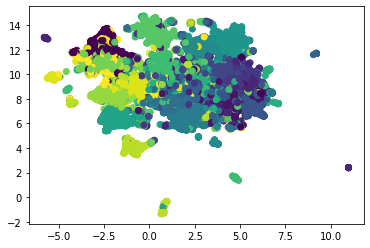

In [30]:
draw_umap(data=vectorized_train, labels=train_labels)

Unfortunately, there is nothing notable

# Evaluation

In [104]:
def evaluate_clustering(labels_true, labels_pred):
    print("V-measure: %0.3f" %
          v_measure_score(labels_true=labels_true, labels_pred=labels_pred))
    print("Homogeneity: %0.3f" %
          homogeneity_score(labels_true=labels_true, labels_pred=labels_pred))
    print("Completeness: %0.3f" %
          completeness_score(labels_true=labels_true, labels_pred=labels_pred))
    print(
        "Adjusted Rand-Index: %.3f" %
        adjusted_rand_score(labels_true=labels_true, labels_pred=labels_pred))

# K-Means with 20 clusters

## With dimensionality reduced data

In [53]:
%%time
kmeans_model = KMeans(n_clusters=20, max_iter=100, n_init=1, verbose=0)
kmeans_model.fit(vectorized_svd_500_train)
kmeans_preds = kmeans_model.predict(vectorized_svd_500_test)

Wall time: 1.04 s


We will use 5 different metrics to evaluate all clustering methods used in this notebook

In [54]:
evaluate_clustering(labels_true=test_labels, labels_pred=kmeans_preds)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_svd_500_train,
                       kmeans_model.labels_,
                       metric='euclidean',
                       sample_size=1000))

V-measure: 0.421
Homogeneity: 0.396
Completeness: 0.449
Adjusted Rand-Index: 0.221
Silhouette Coefficient: 0.030


## With all vectorized data

In [55]:
%%time
kmeans_model = KMeans(n_clusters=20, max_iter=100, n_init=1, verbose=0)
kmeans_model.fit(vectorized_train)
kmeans_preds = kmeans_model.predict(vectorized_test)

evaluate_clustering(labels_true=test_labels, labels_pred=kmeans_preds)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_train,
                       kmeans_model.labels_,
                       metric='euclidean',
                       sample_size=1000))

V-measure: 0.416
Homogeneity: 0.378
Completeness: 0.461
Adjusted Rand-Index: 0.144
Silhouette Coefficient: 0.011
Wall time: 3.41 s


All used metrics are "greater-better. 1 is best". Reduced data and not reduced data gave pretty the same metrics

## Grid search
Let's try to search best parameters for model dealing with redused data (to save time)

We will use V-measure as main score to take into account homogeneity of clusters and their completeness

In [56]:
%%time

v_measure_scorer = make_scorer(v_measure_score)

param_grid = [{
    'max_iter': [10, 100, 1000, 10000],
    'init': ['k-means++', 'random']
}]

grid_KMeans = GridSearchCV(KMeans(n_clusters=20),
                           param_grid=param_grid,
                           cv=5,
                           scoring=v_measure_scorer)

grid_KMeans.fit(vectorized_svd_500_train, train_labels)

Wall time: 3min 44s


GridSearchCV(cv=5, estimator=KMeans(n_clusters=20),
             param_grid=[{'init': ['k-means++', 'random'],
                          'max_iter': [10, 100, 1000, 10000]}],
             scoring=make_scorer(v_measure_score))

In [57]:
grid_KMeans.score(vectorized_svd_500_test, test_labels)

0.41876555380913233

In [59]:
grid_KMeans.best_params_

{'init': 'random', 'max_iter': 100}

In [61]:
kmeans_preds = grid_KMeans.best_estimator_.predict(vectorized_svd_500_test)

evaluate_clustering(labels_true=test_labels, labels_pred=kmeans_preds)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_train,
                       grid_KMeans.best_estimator_.labels_,
                       metric='euclidean',
                       sample_size=1000))

V-measure: 0.419
Homogeneity: 0.392
Completeness: 0.449
Adjusted Rand-Index: 0.203
Silhouette Coefficient: 0.011


We do not see any improvement in comparison with the default parameters

# LDA vectorizer with model

In [62]:
%%time
LDA_data = [doc.split() for doc in data_pd['message']]

# Creating the term dictionary of our courpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(LDA_data)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in LDA_data]

Wall time: 6.83 s


In [65]:
%%time
lda_model = LdaModel(doc_term_matrix,
                     num_topics=20,
                     id2word=dictionary,
                     passes=10)

Wall time: 3min 15s


Let's show finded topics with most common words in them

In [71]:
for el in lda_model.show_topics(num_topics=20, num_words=10):
    print(el, '\n')

(0, '0.013*"lines" + 0.013*"subject" + 0.012*"organization" + 0.006*"sale" + 0.006*"nntppostinghost" + 0.005*"one" + 0.005*"university" + 0.004*"like" + 0.004*"distribution" + 0.004*"get"') 

(1, '0.007*"research" + 0.006*"1993" + 0.005*"health" + 0.005*"medical" + 0.005*"conference" + 0.005*"information" + 0.004*"georgia" + 0.004*"april" + 0.004*"center" + 0.004*"university"') 

(2, '0.011*"game" + 0.009*"team" + 0.007*"year" + 0.007*"games" + 0.006*"lines" + 0.006*"subject" + 0.006*"organization" + 0.006*"writes" + 0.005*"hockey" + 0.005*"players"') 

(3, '0.010*"writes" + 0.010*"fire" + 0.009*"fbi" + 0.008*"koresh" + 0.007*"article" + 0.007*"lines" + 0.007*"organization" + 0.007*"subject" + 0.007*"batf" + 0.006*"waco"') 

(4, '0.010*"file" + 0.009*"image" + 0.006*"available" + 0.006*"use" + 0.006*"files" + 0.005*"x" + 0.005*"window" + 0.005*"software" + 0.005*"data" + 0.005*"also"') 

(5, '0.005*"gary" + 0.004*"book" + 0.004*"l" + 0.003*"lost" + 0.003*"sternlight" + 0.003*"apr" + 0.

With 10 common words we can see some patterns: 3-about sports, 6-nations, 15-israel, 16-religion and so on. But some clusters are pretty similar and have similar common words (like "subject", "organization" and so on). 

# Selecting the number of clusters

For n_clusters = 2 the average silhouette_score is : 0.007749471117587077
For n_clusters = 3 the average silhouette_score is : 0.006430740390797809
For n_clusters = 4 the average silhouette_score is : 0.006485662166897986
For n_clusters = 5 the average silhouette_score is : 0.011274946434114854
For n_clusters = 6 the average silhouette_score is : 0.012341554451699014
For n_clusters = 7 the average silhouette_score is : 0.012426211999683167
For n_clusters = 8 the average silhouette_score is : 0.015304001029987333
For n_clusters = 9 the average silhouette_score is : 0.015594401197047632
For n_clusters = 10 the average silhouette_score is : 0.017827996154097973
For n_clusters = 11 the average silhouette_score is : 0.02116641248144341
For n_clusters = 12 the average silhouette_score is : 0.020974514363119808
For n_clusters = 13 the average silhouette_score is : 0.021120060591772207
For n_clusters = 14 the average silhouette_score is : 0.02246332693112895
For n_clusters = 15 the average sil

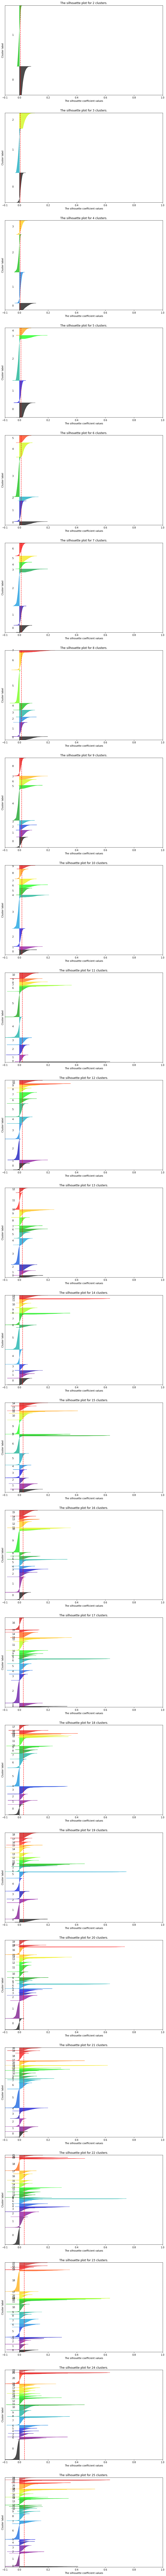

In [37]:
%%time

range_n_clusters = range(2, 26)

fig, ax1 = plt.subplots(len(range_n_clusters), 1)
fig.set_size_inches(12, 200)

for n_clusters in range_n_clusters:

    row = range_n_clusters.index(n_clusters)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1[row].set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1[row].set_ylim([0, len(vectorized_svd_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(vectorized_svd_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(vectorized_svd_data, cluster_labels)
    print("For n_clusters =", n_clusters, "the average silhouette_score is :",
          silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(vectorized_svd_data,
                                                  cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1[row].fill_betweenx(np.arange(y_lower, y_upper),
                               0,
                               ith_cluster_silhouette_values,
                               facecolor=color,
                               edgecolor=color,
                               alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1[row].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1[row].set_title("The silhouette plot for " + str(n_clusters) +
                       " clusters.")
    ax1[row].set_xlabel("The silhouette coefficient values")
    ax1[row].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1[row].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1[row].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[row].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

The best average silhouette score obtained with 24 clusters. But there are two problems: clusters are not balanced and some clusters have very big part of points with negative silhouette score.

# MiniBatchKMeans with 20 clusters

## With dimensionality reduced data

In [74]:
%%time

param_grid = [{
    'max_iter': [10, 100, 1000, 10000],
    'init': ['k-means++', 'random'],
    'batch_size': [10, 20, 30, 50, 100, 1000]
}]

grid_minibatch = GridSearchCV(MiniBatchKMeans(n_clusters=20),
                              param_grid=param_grid,
                              cv=2,
                              scoring=v_measure_scorer)

grid_minibatch.fit(vectorized_svd_500_train, train_labels)

Wall time: 45.1 s


GridSearchCV(cv=2, estimator=MiniBatchKMeans(n_clusters=20),
             param_grid=[{'batch_size': [10, 20, 30, 50, 100, 1000],
                          'init': ['k-means++', 'random'],
                          'max_iter': [10, 100, 1000, 10000]}],
             scoring=make_scorer(v_measure_score))

In [75]:
grid_minibatch.best_params_

{'batch_size': 1000, 'init': 'random', 'max_iter': 10000}

In [78]:
kmeans_preds = grid_minibatch.best_estimator_.predict(vectorized_svd_500_test)

evaluate_clustering(labels_true=test_labels, labels_pred=kmeans_preds)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_train,
                       grid_KMeans.best_estimator_.labels_,
                       metric='euclidean',
                       sample_size=1000))

V-measure: 0.393
Homogeneity: 0.381
Completeness: 0.406
Adjusted Rand-Index: 0.231
Silhouette Coefficient: 0.011


Results of MiniBatchKMeans with dimensionally redused data are worse than the results of the KMeans model

## With all vectorized data

In [79]:
%%time

grid_minibatch = GridSearchCV(MiniBatchKMeans(n_clusters=20), param_grid=param_grid, cv=2, scoring=my_scorer)

grid_minibatch.fit(vectorized_svd_500_train, train_labels)

Wall time: 46.5 s


GridSearchCV(cv=2, estimator=MiniBatchKMeans(n_clusters=20),
             param_grid=[{'batch_size': [10, 20, 30, 50, 100, 1000],
                          'init': ['k-means++', 'random'],
                          'max_iter': [10, 100, 1000, 10000]}],
             scoring=make_scorer(v_measure_score))

In [80]:
grid_minibatch.best_params_

{'batch_size': 1000, 'init': 'k-means++', 'max_iter': 10000}

In [81]:
kmeans_preds = grid_minibatch.best_estimator_.predict(vectorized_svd_500_test)

evaluate_clustering(labels_true=test_labels, labels_pred=kmeans_preds)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_train,
                       grid_KMeans.best_estimator_.labels_,
                       metric='euclidean',
                       sample_size=1000))

V-measure: 0.392
Homogeneity: 0.372
Completeness: 0.415
Adjusted Rand-Index: 0.225
Silhouette Coefficient: 0.011


MiniBatch with all data has worse results.

# DBSCAN with 20 clusters

500 features works very slow so we will reduse dimension again

In [82]:
%%time 

svd_100 = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
svd_100_norm_pipeline = make_pipeline(tfidf_vectorizer, svd_100, normalizer)

vectorized_svd_100_train = svd_100_norm_pipeline.fit_transform(train_data)
# vectorized_svd_100_test = svd_100_norm_pipeline.transform(test_data)

explained_variance = svd_100.explained_variance_ratio_.sum()
print('Explained variance of the SVD step : ', explained_variance)

Explained variance of the SVD step :  0.16212715755093166
Wall time: 43.3 s


In [116]:
%%time

param_grid = [{
    'eps': [1e-2, 1e-1, 0.2, 0.5, 0.8, 1, 1e+1],
    'metric': ["euclidean", "manhattan"],
    'min_samples': [1, 5, 10, 50]
}]

from sklearn.model_selection import ParameterGrid

best_score = -np.inf
best_preds = None
best_params = None

grid = ParameterGrid(param_grid)
for param_set in tqdm(grid, total=len(grid)):
    dbscan = DBSCAN(**param_set)
    dbscan_preds = dbscan.fit_predict(vectorized_svd_100_train)
    score = v_measure_score(labels_true=train_labels, labels_pred=dbscan_preds)
    if score > best_score:
        best_score = score
        best_preds = dbscan_preds
        best_params = param_set

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [07:55<00:00,  8.50s/it]

Wall time: 7min 55s


As DBSCAN doesn't have a prediction function, we will evaluate the algorithm on train

In [121]:
evaluate_clustering(labels_true=train_labels, labels_pred=best_preds)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_svd_100_train,
                       best_preds,
                       metric='euclidean'))

V-measure: 0.483
Homogeneity: 0.911
Completeness: 0.329
Adjusted Rand-Index: 0.033
Silhouette Coefficient: 0.029


The metrics are not bad

# AgglomerativeClustering

## With dimensionality reduced data

In [132]:
%%time

param_grid = [{
    'linkage': ['ward', 'complete', 'average', 'single'],
    'affinity': ["euclidean", "manhattan", 'cosine'],
}]

best_score = -np.inf
best_preds = None
best_params = None

grid = ParameterGrid(param_grid)
for param_set in tqdm(grid, total=len(grid)):
    # If linkage is “ward”, only “euclidean” is accepted
    if param_set['linkage'] == 'ward' and param_set['affinity'] != 'euclidean':
        continue
    aggl = AgglomerativeClustering(n_clusters=20)
    aggl.set_params(**param_set)
    aggl_preds = aggl.fit_predict(vectorized_svd_100_train)
    score = v_measure_score(labels_true=train_labels, labels_pred=aggl_preds)
    if score > best_score:
        best_score = score
        best_preds = aggl_preds
        best_params = param_set

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:01<00:00, 10.09s/it]

Wall time: 2min 1s


In [133]:
evaluate_clustering(labels_true=train_labels, labels_pred=best_preds)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_svd_100_train,
                       best_preds,
                       metric='euclidean'))

V-measure: 0.349
Homogeneity: 0.320
Completeness: 0.384
Adjusted Rand-Index: 0.133
Silhouette Coefficient: 0.063


# Classification methods
Let's launch some classification models to estimate clustering results

## SGD Classifier

### With SVD

In [137]:
param_grid = {
    'loss': ['log', 'modified_huber'],
    'alpha': [4e-3, 5e-3, 2e-3, 1e-3]
}

grid_sdg_clf = GridSearchCV(SGDClassifier(),
                            param_grid=param_grid,
                            cv=5,
                            scoring=v_measure_scorer,
                            verbose=10)

grid_sdg_clf.fit(vectorized_svd_500_train, train_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START alpha=0.004, loss=log.......................................
[CV 1/5; 1/8] END .....................alpha=0.004, loss=log; total time=   1.8s
[CV 2/5; 1/8] START alpha=0.004, loss=log.......................................
[CV 2/5; 1/8] END .....................alpha=0.004, loss=log; total time=   1.7s
[CV 3/5; 1/8] START alpha=0.004, loss=log.......................................
[CV 3/5; 1/8] END .....................alpha=0.004, loss=log; total time=   2.0s
[CV 4/5; 1/8] START alpha=0.004, loss=log.......................................
[CV 4/5; 1/8] END .....................alpha=0.004, loss=log; total time=   1.7s
[CV 5/5; 1/8] START alpha=0.004, loss=log.......................................
[CV 5/5; 1/8] END .....................alpha=0.004, loss=log; total time=   1.7s
[CV 1/5; 2/8] START alpha=0.004, loss=modified_huber............................
[CV 1/5; 2/8] END ..........alpha=0.004, loss=mod

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': [0.004, 0.005, 0.002, 0.001],
                         'loss': ['log', 'modified_huber']},
             scoring=make_scorer(v_measure_score), verbose=10)

In [139]:
sdg_clf_preds = grid_sdg_clf.best_estimator_.predict(vectorized_svd_500_test)

evaluate_clustering(labels_true=test_labels, labels_pred=sdg_clf_preds)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_svd_500_test,
                       sdg_clf_preds,
                       metric='euclidean',
                       sample_size=1000))

V-measure: 0.757
Homogeneity: 0.756
Completeness: 0.759
Adjusted Rand-Index: 0.707
Silhouette Coefficient: 0.020


### Without SVD

In [143]:
%%time

grid_sdg_clf = GridSearchCV(SGDClassifier(),
                            param_grid=param_grid,
                            cv=5,
                            scoring=v_measure_scorer,
                            verbose=10)

grid_sdg_clf.fit(vectorized_train, train_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START alpha=0.004, loss=log.......................................
[CV 1/5; 1/8] END .....................alpha=0.004, loss=log; total time=   0.9s
[CV 2/5; 1/8] START alpha=0.004, loss=log.......................................
[CV 2/5; 1/8] END .....................alpha=0.004, loss=log; total time=   0.8s
[CV 3/5; 1/8] START alpha=0.004, loss=log.......................................
[CV 3/5; 1/8] END .....................alpha=0.004, loss=log; total time=   0.8s
[CV 4/5; 1/8] START alpha=0.004, loss=log.......................................
[CV 4/5; 1/8] END .....................alpha=0.004, loss=log; total time=   0.8s
[CV 5/5; 1/8] START alpha=0.004, loss=log.......................................
[CV 5/5; 1/8] END .....................alpha=0.004, loss=log; total time=   0.8s
[CV 1/5; 2/8] START alpha=0.004, loss=modified_huber............................
[CV 1/5; 2/8] END ..........alpha=0.004, loss=mod

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': [0.004, 0.005, 0.002, 0.001],
                         'loss': ['log', 'modified_huber']},
             scoring=make_scorer(v_measure_score), verbose=10)

In [142]:
sdg_clf_preds = grid_sdg_clf.best_estimator_.predict(vectorized_test)

evaluate_clustering(labels_true=test_labels, labels_pred=sdg_clf_preds)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_test,
                       sdg_clf_preds,
                       metric='euclidean',
                       sample_size=1000))

V-measure: 0.797
Homogeneity: 0.796
Completeness: 0.799
Adjusted Rand-Index: 0.757
Silhouette Coefficient: 0.007


## Logistic Regression

### With SVD

In [144]:
%%time

param_grid = {'C': [1e-3, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2]}

grid_logreg = GridSearchCV(LogisticRegression(),
                            param_grid=param_grid,
                            cv=5,
                            scoring=v_measure_scorer,
                            verbose=10)

grid_logreg.fit(vectorized_svd_500_train, train_labels)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5; 1/7] START C=0.001.....................................................
[CV 1/5; 1/7] END ...................................C=0.001; total time=   0.6s
[CV 2/5; 1/7] START C=0.001.....................................................
[CV 2/5; 1/7] END ...................................C=0.001; total time=   0.3s
[CV 3/5; 1/7] START C=0.001.....................................................
[CV 3/5; 1/7] END ...................................C=0.001; total time=   0.3s
[CV 4/5; 1/7] START C=0.001.....................................................
[CV 4/5; 1/7] END ...................................C=0.001; total time=   0.3s
[CV 5/5; 1/7] START C=0.001.....................................................
[CV 5/5; 1/7] END ...................................C=0.001; total time=   0.3s
[CV 1/5; 2/7] START C=0.001.....................................................
[CV 1/5; 2/7] END ...............................

C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 1/5; 6/7] END ....................................C=10.0; total time=   3.7s
[CV 2/5; 6/7] START C=10.0......................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 2/5; 6/7] END ....................................C=10.0; total time=   3.7s
[CV 3/5; 6/7] START C=10.0......................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 3/5; 6/7] END ....................................C=10.0; total time=   3.7s
[CV 4/5; 6/7] START C=10.0......................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 4/5; 6/7] END ....................................C=10.0; total time=   4.1s
[CV 5/5; 6/7] START C=10.0......................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 5/5; 6/7] END ....................................C=10.0; total time=   3.8s
[CV 1/5; 7/7] START C=100.0.....................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 1/5; 7/7] END ...................................C=100.0; total time=   3.7s
[CV 2/5; 7/7] START C=100.0.....................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 2/5; 7/7] END ...................................C=100.0; total time=   3.7s
[CV 3/5; 7/7] START C=100.0.....................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 3/5; 7/7] END ...................................C=100.0; total time=   3.7s
[CV 4/5; 7/7] START C=100.0.....................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 4/5; 7/7] END ...................................C=100.0; total time=   3.6s
[CV 5/5; 7/7] START C=100.0.....................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 5/5; 7/7] END ...................................C=100.0; total time=   3.7s
Wall time: 1min 15s


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.001, 0.01, 0.1, 1, 10.0, 100.0]},
             scoring=make_scorer(v_measure_score), verbose=10)

In [145]:
logreg_preds = grid_logreg.best_estimator_.predict(vectorized_svd_500_test)

evaluate_clustering(labels_true=test_labels, labels_pred=logreg_preds)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_svd_500_test,
                       logreg_preds,
                       metric='euclidean',
                       sample_size=1000))

V-measure: 0.768
Homogeneity: 0.768
Completeness: 0.769
Adjusted Rand-Index: 0.722
Silhouette Coefficient: 0.020


### Without SVD

In [146]:
%%time

grid_logreg = GridSearchCV(LogisticRegression(),
                            param_grid=param_grid,
                            cv=5,
                            scoring=v_measure_scorer,
                            verbose=10)

grid_logreg.fit(vectorized_train, train_labels)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5; 1/7] START C=0.001.....................................................
[CV 1/5; 1/7] END ...................................C=0.001; total time=   1.1s
[CV 2/5; 1/7] START C=0.001.....................................................
[CV 2/5; 1/7] END ...................................C=0.001; total time=   1.1s
[CV 3/5; 1/7] START C=0.001.....................................................
[CV 3/5; 1/7] END ...................................C=0.001; total time=   0.5s
[CV 4/5; 1/7] START C=0.001.....................................................
[CV 4/5; 1/7] END ...................................C=0.001; total time=   1.0s
[CV 5/5; 1/7] START C=0.001.....................................................
[CV 5/5; 1/7] END ...................................C=0.001; total time=   0.4s
[CV 1/5; 2/7] START C=0.001.....................................................
[CV 1/5; 2/7] END ...............................

C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 1/5; 6/7] END ....................................C=10.0; total time=   7.0s
[CV 2/5; 6/7] START C=10.0......................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 2/5; 6/7] END ....................................C=10.0; total time=   5.8s
[CV 3/5; 6/7] START C=10.0......................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 3/5; 6/7] END ....................................C=10.0; total time=   6.7s
[CV 4/5; 6/7] START C=10.0......................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 4/5; 6/7] END ....................................C=10.0; total time=   5.7s
[CV 5/5; 6/7] START C=10.0......................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 5/5; 6/7] END ....................................C=10.0; total time=   6.1s
[CV 1/5; 7/7] START C=100.0.....................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 1/5; 7/7] END ...................................C=100.0; total time=   5.6s
[CV 2/5; 7/7] START C=100.0.....................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 2/5; 7/7] END ...................................C=100.0; total time=   6.1s
[CV 3/5; 7/7] START C=100.0.....................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 3/5; 7/7] END ...................................C=100.0; total time=   5.4s
[CV 4/5; 7/7] START C=100.0.....................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 4/5; 7/7] END ...................................C=100.0; total time=   6.2s
[CV 5/5; 7/7] START C=100.0.....................................................


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 5/5; 7/7] END ...................................C=100.0; total time=   5.6s
Wall time: 2min


C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.001, 0.01, 0.1, 1, 10.0, 100.0]},
             scoring=make_scorer(v_measure_score), verbose=10)

In [147]:
grid_logreg = grid_logreg.best_estimator_.predict(vectorized_test)

evaluate_clustering(labels_true=test_labels, labels_pred=grid_logreg)
print("Silhouette Coefficient: %0.3f" %
      silhouette_score(vectorized_test,
                       grid_logreg,
                       metric='euclidean',
                       sample_size=1000))

V-measure: 0.820
Homogeneity: 0.820
Completeness: 0.821
Adjusted Rand-Index: 0.788
Silhouette Coefficient: 0.007
